# Generation of the distance matrice and its euclidean space transformation

This is the first part of the pipeline, where the data is preprocessed, distance matrice is generated and transformed into a coordinate matrice with a help of an MDS procedure, implemented in R. 

The data preprocessing includes labels (Y) and features (X) generation in a form of 1d and 2d numpy arrays respectively.

The distance matrice is obtained from the performances of each of the feature subsets on the cross-validation data set. The intrasubset distances are obtained based on the feature_importance parameter of Decision Tree classifier, sklearn implementation.  

# Importing all the necessary modules

In [1]:
import pandas as pd
import gmql as gl
import random
import os
import sys
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.neighbors import DistanceMetric
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import numpy as np
# matplotlib properties
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

get_ipython().run_line_magic('matplotlib', 'inline')
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
matplotlib.rcParams['font.size'] = 22
matplotlib.rcParams['xtick.labelsize'] = 22
matplotlib.rcParams['ytick.labelsize'] = 22
matplotlib.rcParams['axes.labelsize'] = 30
matplotlib.rcParams['axes.titlesize'] = 30

%load_ext autoreload
%autoreload 2

# The file contains implementations of all the used functions with the desciptions

In [2]:
from data_proc_dm_generation import *

Using TensorFlow backend.


# rpy2 module allows on usage of R inside of python

In [3]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
sma = importr('smacof')

# Initialization of all the required parameters

In [53]:
num_iters = 1 #number of iterations for finding the most optimal subset of features. 
#the subset is then subtracted from the list of available features and the operation is repeated 
subset_size = 5 #number of features to be chosen
top_k = 2000 # feature selectrion procedure, where top k features based on chi2 test are taken
tads = True #set to True if you want to work with tads set of genes

# Preprocessing data, generating features and labels for training and testing 

In [54]:
if tads == True:
    path = "/home/nanni/Projects/ML/TAD_Trento/all_tcga_TAD.tsv"
else:
    path = "/home/nanni/Data/TCGA/all_tcga.tsv"

X_train,X_test,Y_train,Y_test, top_inds = get_raw_data(path, top_k, tads)

## Obtaining subsets and their scores, building a distance matrice on its basis, applying MDS, checking the preservation of the nearest neighbors

In [55]:
scores, ranks, inds = cluster_generator_wrapper_subsets(X_train, Y_train, num_iters, subset_size, top_k)

/home/sakalouski/.conda/envs/artur/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [47]:
dist_final = get_distance_matrix(scores, inds, ranks, X_train.shape[1])
R_mds = np.array(sma.torgerson(dist_final, p = dist_final.shape[0]-1))

In [8]:
preservation = check_preservation_of_dims(R_mds.T, dist_final, subset_size)
#subset_size is number of nearest neighbors
print(preservation)

Computing distances in MDSres
Finding nearest neighbors
1.0


## Getting the disntaces from the TADs distance matrix for top_k genes 

In [48]:
path_MDS = '/home/sakalouski/TAD_Trento/distance matrices/MDSes/interTADs_dists_all_15k.csv'
R_mds = pd.read_csv(path_MDS, header = None).as_matrix()

In [56]:
R_mds_selected = R_mds[top_inds,:]

## Plotting distance matrice and coorinates matrice as heatmaps and values distributions 

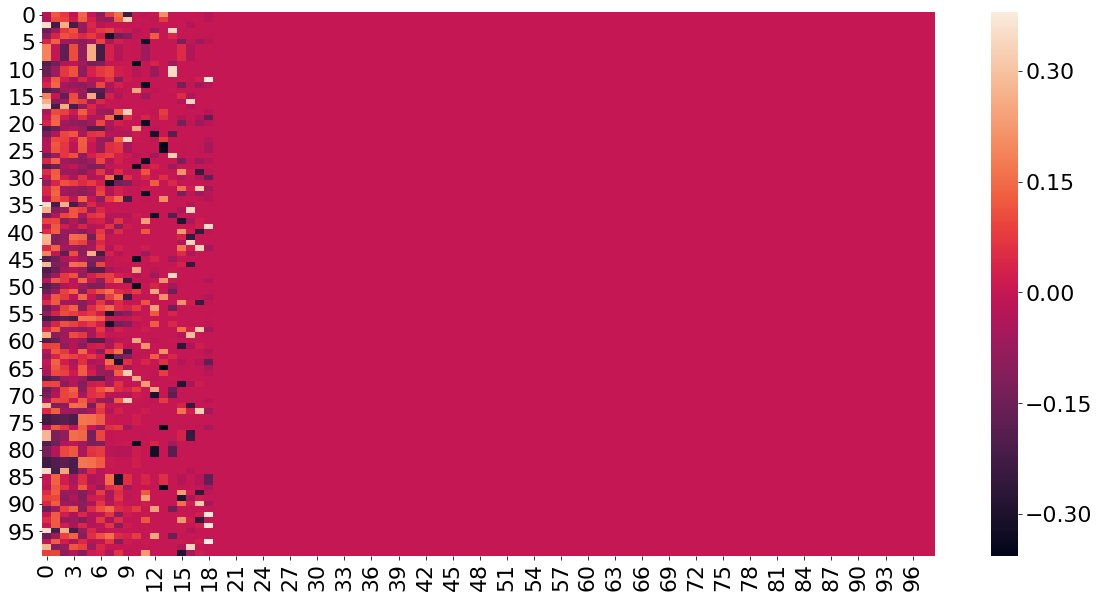

1900

In [9]:
sns.heatmap(R_mds)
plt.show()
np.count_nonzero(R_mds)

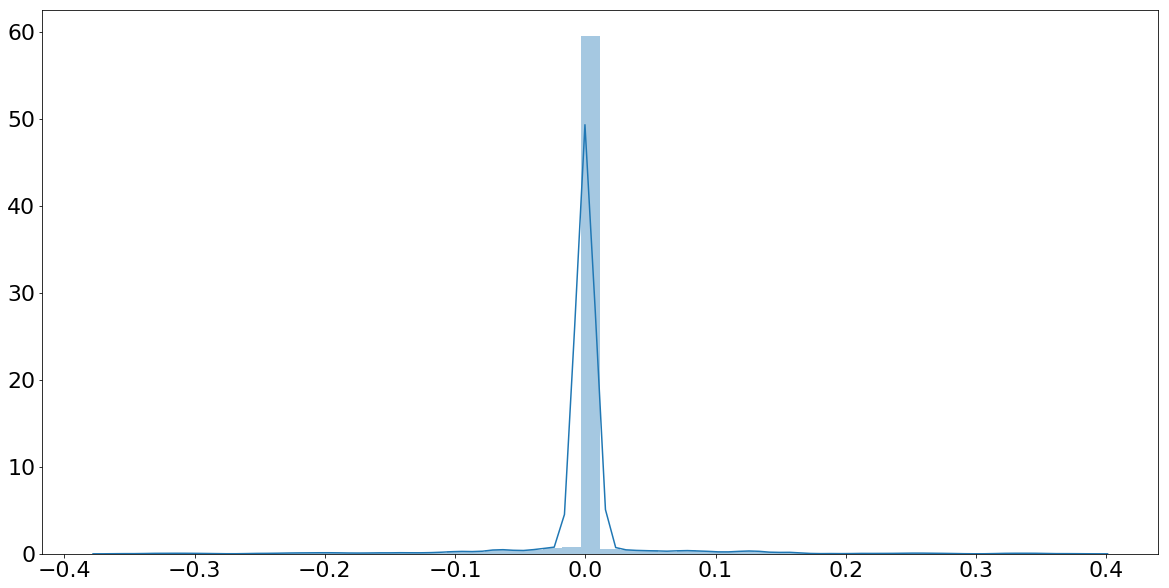

In [10]:
sns.distplot(R_mds.flatten())
plt.show()

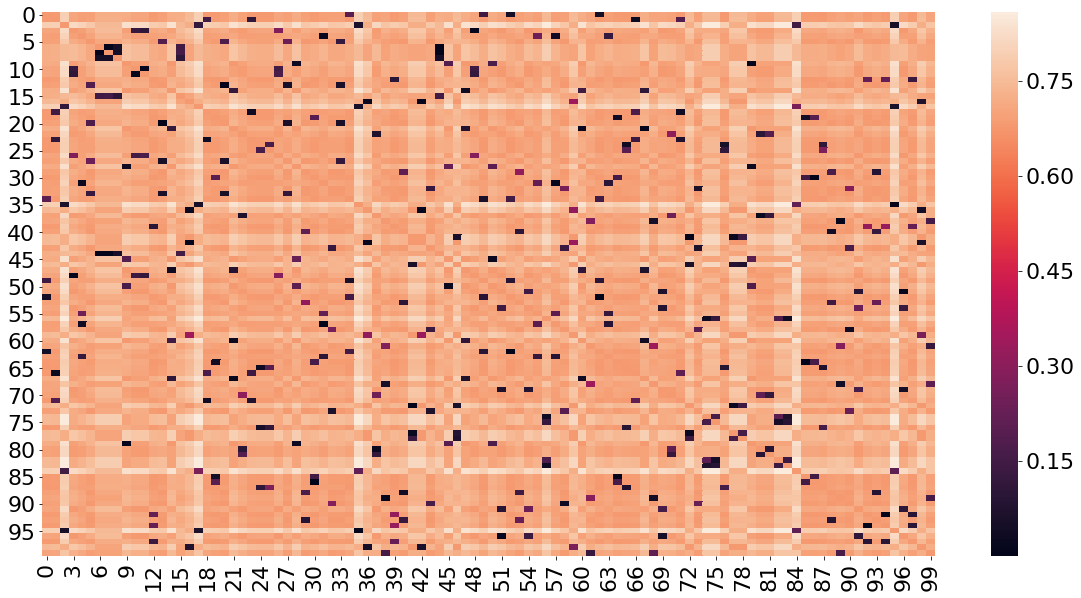

In [11]:
sns.heatmap(dist_final)
plt.show()

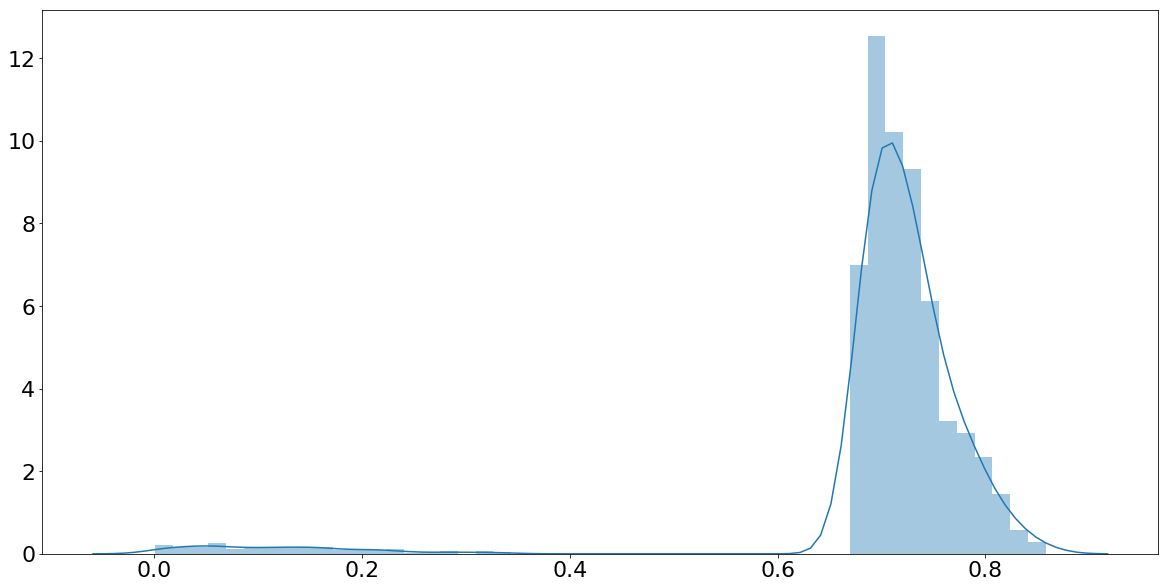

In [12]:
sns.distplot(dist_final.flatten())
plt.show()

# Saving coordinates matrice to file

In [13]:
#np.save('test',R_mds)

# Second part of the pipeline - DL setup

## Imports 

In [14]:
from keras import backend as K
import tensorflow as tf
config = tf.ConfigProto(device_count = {'CPU': 1}, intra_op_parallelism_threads=7, inter_op_parallelism_threads=1)
session = tf.Session(config=config)
K.set_session(session)

import keras as k
import keras
from keras import applications
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.layers import Input

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from keras.layers import (Lambda, MaxPooling1D, Flatten,
                          Dropout, Dense, Input)
from keras.models import Model
from keras.backend import floatx
from phcnn.layers import PhyloConv1D, euclidean_distances
from keras.utils.np_utils import to_categorical


In [30]:
batch_size = 100
nb_filters = 5
nb_neighbors = 5
model_name = 'test'

## Making the results reproducible

In [57]:
seed = 7
np.random.seed(seed)

# Load the coordinates matrice in case of using an external one

In [17]:
#R_mds = np.load('test.npy')

## Reshaping MDS represenation

In [58]:
MDSmat = mds_reshape(R_mds_selected, batch_size)

# Reshaping X and Y to the suitable form

In [59]:
Y_input_test = keras.utils.to_categorical(Y_test, num_classes=None)
Y_input_train = keras.utils.to_categorical(Y_train, num_classes=None)

X_test_inp = X_test.reshape(X_test.shape[0],X_test.shape[1],-1)
X_train_inp = X_train.reshape(X_train.shape[0],X_train.shape[1],-1)

# Creating and training the model. Validation loss is printed

In [ ]:
model = create_model(X_train_inp, Y_input_train, MDSmat, nb_filters, nb_neighbors)
model_trained = train_model(model, X_train_inp, Y_input_train, batch_size, 7, 30, model_name, MDSmat, dense = False)   

## Plotting validation and training loss functions

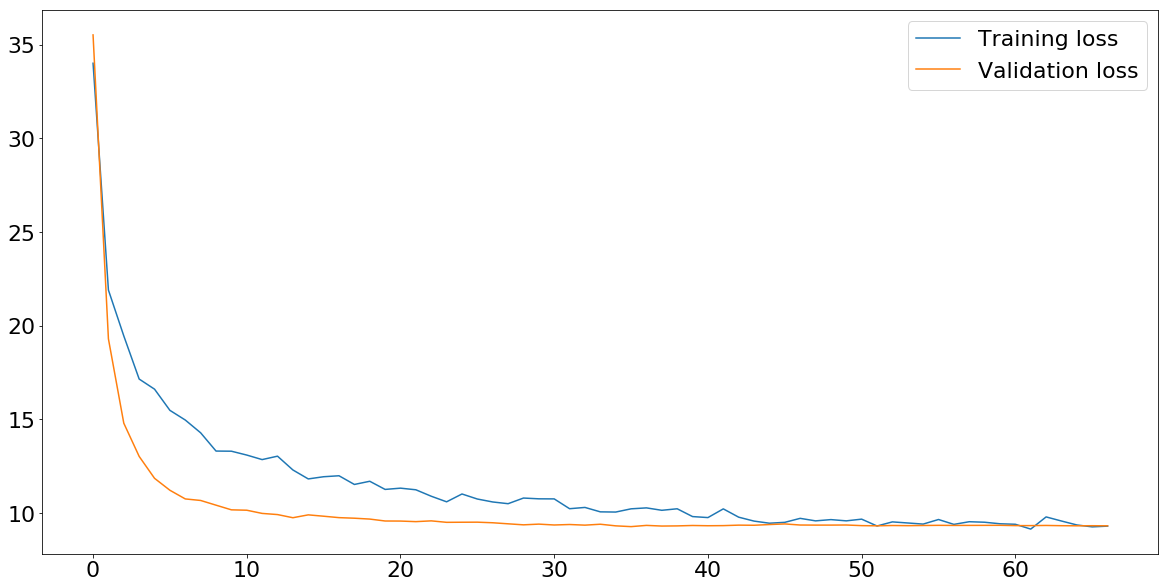

In [43]:
val_loss = np.load('val_loss_'+model_name+'.npy')
train_loss = np.load('train_loss_'+model_name+'.npy')
x_axis = range(0,len(val_loss))
plt.plot(x_axis,train_loss, label='Training loss')
plt.plot(x_axis,val_loss,  label='Validation loss')
plt.legend()
plt.show()

## Evaluating the performance on the test set

In [40]:
Y_pred = np.array(Y_input_test)
for i in range(0,Y_pred.shape[0]):
    Y_pred[i,:] = model_trained.predict(x = [X_test_inp[[i],:,:], MDSmat[1:2:,:,:,:]])

Y_pred_1d = to_1d_labels(Y_pred)
rep = classification_report(Y_test,Y_pred_1d)
print(rep)

             precision    recall  f1-score   support

          1       0.79      0.75      0.77       157
          2       0.94      0.88      0.91       417
          3       0.35      0.36      0.35        98
          4       0.40      0.51      0.45        93
          5       0.64      0.51      0.56       192
          6       0.18      0.77      0.30        31
          7       0.82      0.51      0.63       192
          8       0.85      0.41      0.55        98
          9       0.51      1.00      0.67        64
         10       0.71      0.80      0.75       135
         11       0.79      0.74      0.77       190
         12       0.99      0.90      0.95       182
         13       0.98      0.88      0.93       185
         14       0.47      0.92      0.62        36

avg / total       0.78      0.73      0.74      2070

